In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import os
import glob
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from pathlib import Path
from cgpt_transformer_model import *
import torch.onnx


C:\Users\cjh9fw\AppData\Local\anaconda3\envs\keras-tt\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Gesture Recognition Accuracy
gesture:  S1 accuracy:  0.9248554913294798

Gesture Recognition Accuracy
gesture:  S2 accuracy:  0.4347826086956522

Gesture Recognition Accuracy
gesture:  S3 accuracy:  0.7613636363636364

Gesture Recognition Accuracy
gesture:  S4 accuracy:  0.8956521739130435

Gesture Recognition Accuracy
gesture:  S5 accuracy:  0.9415204678362573

Gesture Recognition Accuracy
gesture:  S6 accuracy:  0.6973684210526316

Gesture Recognition Accuracy
gesture:  S7 accuracy:  0.9671052631578947

Gesture Recognition Accuracy
gesture:  S1 accuracy:  0.8666666666666667

Gesture Recognition Accuracy
gesture:  S2 accuracy:  0.21052631578947367

Gesture Recognition Accuracy
gesture:  S3 accuracy:  0.7211538461538461

Gesture Recognition Accuracy
gesture:  S4 accuracy:  0.8114754098360656

Gesture Recognition Accuracy
gesture:  S5 accuracy:  0.9952830188679245

Gesture Recognition Accuracy
gesture:  S6 accuracy:  0.5039370078740157

Gesture Recognition Accuracy
gesture:  S7 accuracy

C:\Users\cjh9fw\AppData\Local\Temp\ipykernel_13864\1582791462.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_changes_df.drop(columns=pred_changes_df.columns[0], axis=1, inplace=True)


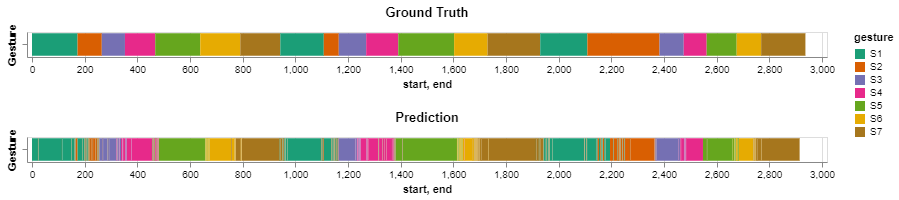

In [219]:

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "64_4_2_01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME


# testing preprocessing

test_path_csv = "./dataset/peg_transfer/labeled/gestures/Gesture_Labeled_Peg_Transfer_S01_T01.csv"
# test_path_csv = "./dataset/peg_transfer/labeled/gestures/gesture_seperated/S7_all_trials.csv"
test_path_txt = "./dataset/peg_transfer/gestures/Peg_Transfer_S01_T01.txt"

test = pd.read_csv(test_path_csv)
# test = test.drop(test.columns[[0,-1]], axis=1) # only for gesture_seperated
test_label = pd.read_csv(test_path_txt, delim_whitespace=' ', header=None, names= ["start","end","gesture","valid"])


le = preprocessing.LabelEncoder()
targets = le.fit_transform(test.iloc[:,-1:].values)
y_test = torch.as_tensor(targets)
# print(y_test)

# everything except last column (gesture)
x_vals = test.iloc[:,:-1]
X_test = torch.tensor(x_vals.values)
# print(X_train.shape[-1])

X_test = X_test.to(torch.float32)

model = TransformerModel(input_dim=X_test.shape[-1], output_dim=7, d_model=64, nhead=4, num_layers=2)
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

test = test.reset_index()
test["gesture"] = test["gesture"].map({'S1':1,
          'S2':2,
          'S3':3,
          'S4':4,
          'S5':5,
          'S6':6,
          'S7':7})



# entire trial recognition

predicted_gestures_total = []

for idx,row in test_label.iterrows():
    gesture_start = row["start"]
    gesture_end = row["end"]
    gesture = row["gesture"]
    
    # print(gesture_start,gesture_end )
    
    y_pred = model(X_test[gesture_start:gesture_end])


    relu = nn.ReLU()

    predicted_gestures = []
    for idx,y in enumerate(y_pred) :
        pred_gesture = np.argmax(relu(y).detach())

        # print("sample: ",idx, "gesture: ",pred_gesture)
        predicted_gestures.append(pred_gesture.numpy()+1)
        predicted_gestures_total.append(pred_gesture.numpy()+1)

        probs = nn.functional.softmax(relu(y),dim=0)
        conf, classes = torch.max(probs, 0)
        conf_prcnt = round(conf.item(), 2) * 100
        # if(conf_prcnt < 80):
        #     print("not confident")
        # print(idx,predicted_gestures[idx], conf_prcnt)


    predicted_gestures_df = pd.DataFrame(predicted_gestures)
    predicted_gestures_df.columns = ["gesture"]

    predicted_gestures_df = predicted_gestures_df.reset_index()

    # predicted_gestures_df.plot( kind='scatter', x='index', y='gesture',
    #                            c=predicted_gestures_df['gesture'],
    #                                    colormap='viridis',
    #                                    legend = True)



    ''' numerical results generation '''

    erroneous_gesture_preds_count = 0
    for idx,y in enumerate(predicted_gestures) :
        if y != test["gesture"][idx+gesture_start]:
            # print("gt: data_index=" + str(idx) + " gesture: S" + str(test["gesture"][idx]))
            # print("pred: data_index=" + str(idx) + " gesture: S" + str(y))
            # print()
            erroneous_gesture_preds_count += 1

    total_data_points = len(predicted_gestures)

    mis_pred_percentage = erroneous_gesture_preds_count/total_data_points
    accuracy = 1 - mis_pred_percentage

    print("Gesture Recognition Accuracy")
    print("gesture: ",gesture, "accuracy: ",accuracy)
    print()


predicted_gestures_df = pd.DataFrame(predicted_gestures_total)
predicted_gestures_df.columns = ["gesture"]

predicted_gestures_df = predicted_gestures_df.reset_index()

# predicted_gestures_df.plot( kind='scatter', x='index', y='gesture',
#                            c=predicted_gestures_df['gesture'],
#                                    colormap='viridis',
#                                    legend = True)

pred_plot_title = "Recognition: "+test_path_txt.split('/')[-1]
gt_plot_title = "Ground Truth: "+test_path_txt.split('/')[-1]

# ax = test.plot( x="index", y = "gesture" ,title = gt_plot_title, xlabel = "sample_index",  ylabel = "gesture")


pred_index_changes = predicted_gestures_df["gesture"].diff()[predicted_gestures_df["gesture"].diff() != 0].index.values

# print(predicted_gestures_df.iloc[pred_index_changes])

pred_changes_df = predicted_gestures_df.iloc[pred_index_changes]
pred_changes_df.reset_index(inplace=True)
pred_changes_df.drop(columns=pred_changes_df.columns[0], axis=1, inplace=True)
# print(pred_changes_df)


pred_index_changes_labels = []

for idx,row in pred_changes_df.iterrows():
    if(idx < pred_changes_df.shape[0]-1):
        pred_index_changes_labels.append([pred_changes_df.iloc[idx]["index"], pred_changes_df.iloc[idx+1]["index"], pred_changes_df.iloc[idx]["gesture"]])



pred_index_changes_labels_df  = pd.DataFrame(pred_index_changes_labels)
pred_index_changes_labels_df.columns = ["start","end","gesture"]

pred_index_changes_labels_df["gesture"] = pred_index_changes_labels_df["gesture"].map({1:"S1",
          2:'S2',
          3:'S3',
          4:'S4',
          5:'S5',
          6:'S6',
          7:'S7'})


import altair as alt
import datetime as dt


alt.renderers.enable('jupyterlab')


gt = alt.Chart(test_label).encode(
    x=alt.X('start', scale=alt.Scale(domain=[0,3000])),
    x2='end',
    y=alt.Y('sum(gesture)',title = "Gesture", axis=alt.Axis(labels=False)),
    color=alt.Color('gesture', scale=alt.Scale(scheme='dark2'))
).properties(
    width=800,
    height=25,
    title="Ground Truth"
)

alt.renderers.enable('jupyterlab')

pred = alt.Chart(pred_index_changes_labels_df).mark_bar(clip=True).encode(
    x=alt.X('start', scale=alt.Scale(domain=[0,3000])),
    x2='end',
    y=alt.Y('sum(gesture)',title = "Gesture", axis=alt.Axis(labels=False)),
    color=alt.Color('gesture', scale=alt.Scale(scheme='dark2'))
).properties(
    width=800,
    height=25,
    title="Prediction"

)

alt.vconcat(
gt.mark_bar(clip=True),
pred.mark_bar(clip=True),
)


# ax = predicted_gestures_df.plot(x="index", title = pred_plot_title, xlabel = "sample_index", ylabel = "gesture")


# '''  chunk by chunk recognition '''

# x_test_chunks = []
# for idx,sample in enumerate(X_test):
#     x_test_chunks.append(sample)
#     if(idx%100 == 0):
#         # print(sample)
#         stacked_tensor = torch.stack(x_test_chunks)
#         y_pred = model(stacked_tensor)
    
    
#         # recognize entire trial #
#         # y_pred = model(X_test)


#         relu = nn.ReLU()

#         predicted_gestures = []
#         for idx,y in enumerate(y_pred) :
#             pred_gesture = np.argmax(relu(y).detach())

#             # print("sample: ",idx, "gesture: ",pred_gesture)
#             predicted_gestures.append(pred_gesture.numpy()+1)


#         predicted_gestures_df = pd.DataFrame(predicted_gestures)
#         predicted_gestures_df.columns = ["gesture"]

#         predicted_gestures_df = predicted_gestures_df.reset_index()

#         # predicted_gestures_df.plot( kind='scatter', x='index', y='gesture',
#         #                            c=predicted_gestures_df['gesture'],
#         #                                    colormap='viridis',
#         #                                    legend = True)

#         pred_plot_title = "Recognition: "+test_path_txt.split('/')[-1]
#         gt_plot_title = "Ground Truth: "+test_path_txt.split('/')[-1]


#         predicted_gestures_df.plot(x="index", title = pred_plot_title, xlabel = "sample_index", ylabel = "gesture")



